In [1]:
import os
import time

import numpy as np
from astropy.time import Time

from pyuvdata import UVData

import matplotlib.pyplot as plt

In [2]:
rime_fast_orig = '/Volumes/Data1/ionrime_bda_sims/pnt_src_300m_baselines_Dec_20_int_time_0.1.uvh5'
rime_slow_orig = '/Volumes/Data1/ionrime_bda_sims/pnt_src_300m_baselines_Dec_20_int_time_2.0.uvh5'
rime_fast_orig_basename, file_extension = os.path.splitext(os.path.basename(rime_fast_orig))
rime_slow_orig_basename, file_extension = os.path.splitext(os.path.basename(rime_slow_orig))

fast_int_time = 0.1
slow_int_time = 2.0

In [3]:
# Fix input files to have narrower freq. channel width to make sure it isn't driving the decorrelation calcs
file_fast_fixed='/Volumes/Data1/bda_outputs/' + rime_fast_orig_basename + '_fixed.uvh5'
file_slow_fixed='/Volumes/Data1/bda_outputs/' + rime_slow_orig_basename + '_fixed.uvh5'

# save phased files because phasing is slow with so many times
rime_fast_fixed_basename, file_extension = os.path.splitext(os.path.basename(file_fast_fixed))
rime_slow_fixed_basename, file_extension = os.path.splitext(os.path.basename(file_slow_fixed))
# for fast file: time to do phasing: 7703.8781061172485 seconds
# for slow file: time to read file into a uvdata object, phased it and write it out: 365.0287299156189 seconds

file_fast_phased='/Volumes/Data1/bda_outputs/' + rime_fast_fixed_basename + '_phased.uvh5'
file_slow_phased='/Volumes/Data1/bda_outputs/' + rime_slow_fixed_basename + '_phased.uvh5'

file_dict = {'fast': {'orig': rime_fast_orig, 'fixed': file_fast_fixed, 'phased': file_fast_phased},
             'slow': {'orig': rime_slow_orig, 'fixed': file_slow_fixed, 'phased': file_slow_phased}}

for sim, stage_dict in file_dict.items():
    if not os.path.isfile(stage_dict['phased']):
        t0 = time.time()
        uv = UVData()
        if not os.path.isfile(stage_dict['fixed']):
            uv.read(stage_dict['orig'], run_check_acceptability=False)
            uv.channel_width=1000. # 1kHz to make sure it isn't driving the decorrelation calcs
        else:
            uv.read(stage_dict['fixed'], run_check_acceptability=False)
        uv.phase_to_time(Time(uv.time_array[0], format='jd'))
        uv.write_uvh5(stage_dict['phased'])
        t1 = time.time()
        print('time to read file into a uvdata object, phased it and write it out: {t} seconds'.format(t=t1-t0))



In [4]:
t0 = time.time()
uv_fast_in = UVData()
uv_fast_in.read(file_fast_phased, run_check_acceptability=False)
t1 = time.time()
print('time to read in file: {t} seconds'.format(t=t1-t0))




Telescope probably HERA, but who knows? is not in known_telescopes.


time to read in file: 41.62505006790161 seconds


In [5]:
uv_fast_integrated = uv_fast_in.copy()

In [6]:
t0 = time.time()
uv_fast_integrated.bda_downsample(2.)
t1 = time.time()
print('time to do bda downsample: {t} seconds'.format(t=t1-t0))
    


time to do bda downsample: 847.7050068378448 seconds


In [7]:
uv_fast_integrated.data_array.shape

(86160, 1, 16, 4)

In [8]:
t0 = time.time()
uv_slow_in = UVData()
uv_slow_in.read(file_slow_phased, run_check_acceptability=False)
t1 = time.time()
print('time to read in file: {t} seconds'.format(t=t1-t0))



Telescope probably HERA, but who knows? is not in known_telescopes.


time to read in file: 2.2012650966644287 seconds


In [27]:
uv_fast_integrated.reorder_blts()
uv_slow_in.reorder_blts()

In [9]:
uv_slow_in.data_array.shape

(86160, 1, 16, 4)

In [10]:
np.max(uv_fast_integrated.integration_time)

2.0000000000000004

In [11]:
np.min(uv_fast_integrated.integration_time)

2.0000000000000004

In [12]:
np.max(uv_slow_in.integration_time)

2.0

In [28]:
np.max(uv_slow_in.baseline_array - uv_fast_integrated.baseline_array)

0

In [29]:
diff_time = uv_slow_in.time_array - uv_fast_integrated.time_array
print(np.max(np.abs(diff_time)) * (24*3600))
print(np.min(np.abs(diff_time)) * (24*3600))

1.9000500440597534
1.8999695777893066


In [30]:
print((uv_slow_in.time_array[0] - np.floor(uv_slow_in.time_array[0]))* (24*3600))
print((uv_fast_integrated.time_array[0] - np.floor(uv_fast_integrated.time_array[0]))* (24*3600))

35451.62907242775
35453.52904200554


In [31]:
np.unique(uv_fast_integrated.time_array).size

21540

In [32]:
uv_slow_matched = uv_slow_in.select(times=np.unique(uv_slow_in.time_array)[1:], inplace=False)
uv_fast_integrated_matched = uv_fast_integrated.select(times=np.unique(uv_fast_integrated.time_array)[:-1], inplace=False)

In [33]:
diff_time = uv_slow_matched.time_array - uv_fast_integrated_matched.time_array
print(np.max(np.abs(diff_time)) * (24*3600))

0.10005980730056763


In [34]:
diff_uvw = uv_slow_matched.uvw_array - uv_fast_integrated_matched.uvw_array
print(np.max(np.abs(diff_uvw)))

0.02301937025741907


bin centers:
[0.    0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011
 0.012 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02  0.021 0.022 0.023]


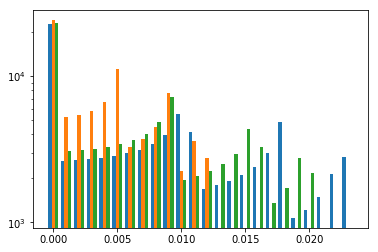

In [38]:
# bin at 1 mm
bin_width = 0.001

# calculate length from 0 to max diff + 1 bin
max_bin = np.round(np.max(np.abs(diff_uvw))/bin_width) + 1
length = max_bin + 1

# center bins so numerical fluctuations don't cause splits between bins
bin_edges = np.arange(length)*bin_width-bin_width/2

bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
print('bin centers:')
print(bin_centers)

plt.hist(np.abs(diff_uvw), bin_edges, log=True)
plt.show()

In [35]:
diff_data = uv_slow_in.data_array - uv_fast_integrated.data_array

In [36]:
np.max(np.abs(diff_data))

0.007303429